In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/ufi.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/vfl.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/sohu.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/rdcm.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/virt.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/hylb.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/skt.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/asix.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/mac.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/gut.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/ngs.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/vpg.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/ibtx.us.txt
/kaggle/input/price-volume-data-for-all-us-st

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

2025-04-27 04:57:26.595676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745729846.800344      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745729846.858764      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
!pip install plotly
import plotly.express as px
import plotly.graph_objects as go


In [4]:
# Load dataset
data = pd.read_csv('/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/aapl.us.txt')  # <- Update path if needed

# Show first few rows
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


In [5]:
# Check info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8364 entries, 0 to 8363
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     8364 non-null   object 
 1   Open     8364 non-null   float64
 2   High     8364 non-null   float64
 3   Low      8364 non-null   float64
 4   Close    8364 non-null   float64
 5   Volume   8364 non-null   int64  
 6   OpenInt  8364 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 457.5+ KB


In [6]:
# Check missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64


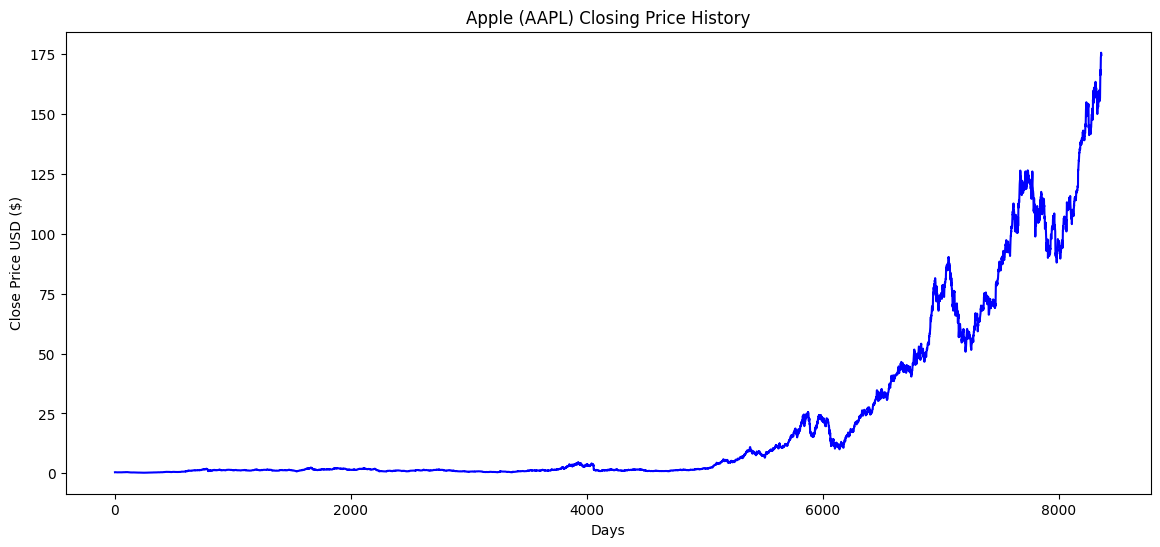

In [7]:
# Plot Closing Price history
plt.figure(figsize=(14,6))
plt.plot(data['Close'], color='blue')
plt.title('Apple (AAPL) Closing Price History')
plt.xlabel('Days')
plt.ylabel('Close Price USD ($)')
plt.show()

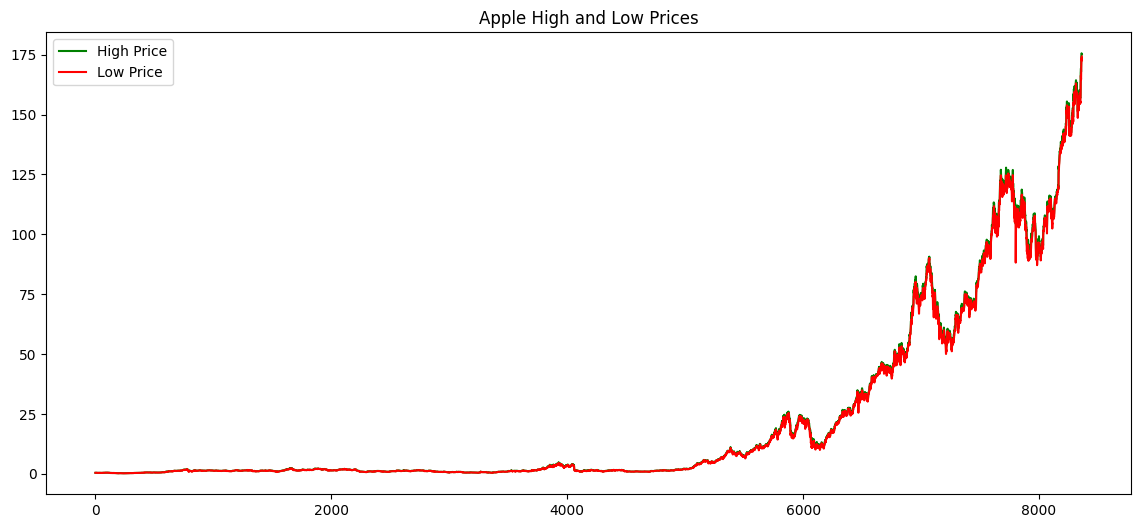

In [8]:
# Plot High vs Low Price
plt.figure(figsize=(14,6))
plt.plot(data['High'], label='High Price', color='green')
plt.plot(data['Low'], label='Low Price', color='red')
plt.title('Apple High and Low Prices')
plt.legend()
plt.show()

In [9]:
# --- Preprocessing ---

# Use only 'Close' price for prediction
closing_data = data[['Close']]

# Scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_data)

# Create sequences (60 days of data to predict the next day)
X = []
y = []

for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

In [10]:
# Reshape X to be 3D [samples, time_steps, features] for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
# --- Build LSTM Model ---

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

I0000 00:00:1745729863.725216      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745729863.725867      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# --- Train Model ---
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50


I0000 00:00:1745729868.469892      70 cuda_dnn.cc:529] Loaded cuDNN version 90300


208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.6361e-04 - val_loss: 4.6435e-04
Epoch 2/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.3291e-05 - val_loss: 3.4773e-04
Epoch 3/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.1684e-05 - val_loss: 7.5782e-04
Epoch 4/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.1689e-05 - val_loss: 0.0023
Epoch 5/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.3278e-05 - val_loss: 0.0017
Epoch 6/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.1219e-05 - val_loss: 0.0056
Epoch 7/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.2431e-05 - val_loss: 4.8322e-04
Epoch 8/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.3966e-05 - val_loss: 5.9179e-04
Epoch 9/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.1786e-05 - val_loss: 0.0046
Epoch 10/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.9856e-05 - val_loss: 0.0015
Epoch 11/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.7548e-05 - val_loss: 0.002

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history['loss'], name='Training Loss'))
fig.add_trace(go.Scatter(y=history.history['val_loss'], name='Validation Loss'))
fig.update_layout(title='Model Loss Over Epochs', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()


In [15]:
# --- Predictions ---
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1,1))

# Inverse scale y_test for comparison
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


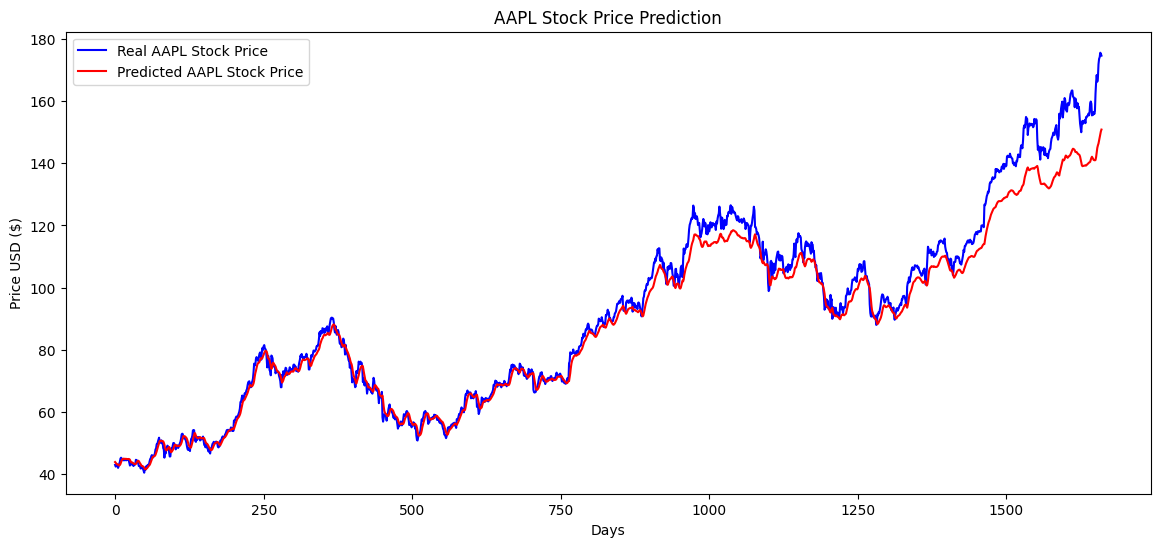

In [16]:
# --- Plot Real vs Predicted ---
plt.figure(figsize=(14,6))
plt.plot(y_test_scaled, color='blue', label='Real AAPL Stock Price')
plt.plot(predictions, color='red', label='Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price USD ($)')
plt.legend()
plt.show()


In [17]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate metrics
mse = mean_squared_error(y_test_scaled, predictions)
r2 = r2_score(y_test_scaled, predictions)
rmse = np.sqrt(mse)

# Print all results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error (MSE): 33.7630
Root Mean Squared Error (RMSE): 5.8106
R² Score: 0.9653
